<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/nbody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
from jax import jit
from jax import vmap
import jax
from numpy import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install tensor-canvas

In [3]:
!pip install moviepy

In [4]:
import tensorcanvas as tc

In [5]:
#@title VideoWriter
#VideoWriter from Alexander Mordvintsev 
#https://colab.research.google.com/github/znah/notebooks/blob/master/external_colab_snippets.ipynb

import os
import numpy as np
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

In [76]:
def draw_sim(parts_pos, parts_vel, grid_r_x, grid_r_y, opacity=1.0, p_size=4.0, pcol=jnp.array([1.0,0.0,0.0])):
  canvas = jnp.zeros((grid_r_y, grid_r_x, 3))
  col = opacity*pcol
  # would be interesting to use jax.experimental.loops for these
  for part_p, part_v in zip(parts_pos, parts_vel):
    canvas = tc.draw_circle(part_p[0]*grid_r_y+grid_r_x*0.5-grid_r_y*0.5, part_p[1]*grid_r_y, p_size, col, canvas)
  return jnp.clip(canvas, 0.0, 1.0)

In [77]:
def draw_sim_par(parts_pos, parts_vel, grid_r_x, grid_r_y, opacity=1.0, p_size=4.0, pcol=jnp.array([1.0,0.0,0.0])):
  col = opacity*pcol
  draw_single = lambda part_p, canv: tc.draw_circle(part_p[0]*grid_r_y+grid_r_x*0.5-grid_r_y*0.5, part_p[1]*grid_r_y, p_size, col, canv)
  draw_all = vmap(draw_single)
  return jnp.clip(draw_all(parts_pos, jnp.zeros((parts_pos.shape[0], grid_r_y, grid_r_x, 3))).sum(0), 0.0, 1.0)

In [78]:
def compute_forces(pos, scale, eps=0.1):
  a, b = jnp.expand_dims(pos, 1), jnp.expand_dims(pos, 0)
  diff = a - b
  dist = (diff * diff).sum(axis=-1) ** 0.5
  dist = jnp.expand_dims(dist, 2)
  force = diff / ((dist * scale) ** 3 + eps)
  return force.sum(0)

fast_compute_forces = jit(compute_forces)

In [79]:
def sim_update_force(parts_pos, parts_vel, t_delta=0.05, scale=5, repel_mag=0.1, center_mag=2.5, steps=10, damp=0.99):
  p_p = jnp.array(parts_pos)
  p_v = jnp.array(parts_vel)
  # jax.experimental.loops
  for _ in range(steps):
    p_p = p_p + t_delta * p_v
    force = fast_compute_forces(p_p, scale)
    center_diff = p_p-0.5
    centering_force = center_diff / ((center_diff ** 2).sum() ** 0.5)
    p_v = damp * p_v - t_delta * (force * repel_mag + centering_force * center_mag)
  return p_p, p_v

In [80]:
def make_init_state(p_count):
  return random.rand(p_count, 2), random.rand(p_count, 2)-0.5

In [81]:
fast_draw = jit(draw_sim, static_argnums=(2,3))
fast_draw_par = jit(draw_sim_par, static_argnums=(2,3))
fast_sim_update_force = jit(sim_update_force, static_argnames=('steps'))

100% 1000/1000 [00:00<00:00, 2083.09it/s]


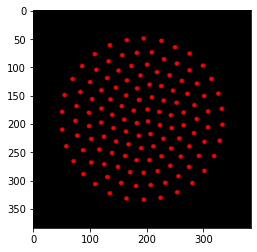

In [82]:
p_state, v_state = make_init_state(128)
v_state *= 0
grid_res = 384
for i in tqdm(range(1000)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, grid_res, p_size=4.0))

100% 100/100 [00:01<00:00, 72.13it/s]


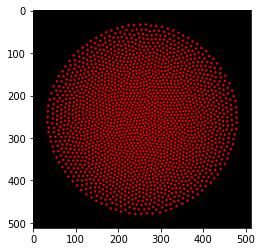

In [83]:
p_state, v_state = make_init_state(2048)
v_state *= 0
grid_res = 512
for i in tqdm(range(100)):
  p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=40, center_mag=0.5, repel_mag=0.05, damp=0.997, steps=20)
plt.imshow(fast_draw_par(p_state, v_state, grid_res, grid_res, p_size=3.0))


In [87]:
render_video = False

In [88]:
if render_video:
  p_state, v_state = make_init_state(128)
  v_state *= 0
  grid_res = 384
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, grid_res, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=10, center_mag=0.5, repel_mag=0.05, damp=0.996, steps=2)

In [89]:
if render_video:
  p_state, v_state = make_init_state(512)
  v_state *= 0
  grid_res = 256
  with VideoWriter(fps=60) as vw:
    for i in tqdm(range(1000)):
        render = fast_draw_par(p_state, v_state, grid_res, grid_res, opacity=0.5, p_size=3.0)
        vw.add(render)
        p_state, v_state = fast_sim_update_force(p_state, v_state, t_delta=0.05, scale=20, center_mag=0.5, repel_mag=0.05, damp=0.998, steps=4)

In [90]:
!nvidia-smi

Mon Oct  4 03:01:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:09:00.0 Off |                  N/A |
| 15%   56C    P2    75W / 150W |  10078MiB / 11177MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
p_test = 50
res_test = 512

In [57]:
%%timeit
draw_sim(*make_init_state(p_test), res_test, res_test)

287 ms ± 5.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%%timeit
draw_sim_par(*make_init_state(p_test), res_test, res_test)

19 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
%%timeit
fast_draw(*make_init_state(p_test), res_test, res_test)

1.99 ms ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [75]:
%%timeit
fast_draw_par(*make_init_state(p_test), res_test, res_test)

1.03 ms ± 8.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [61]:
import ffmpeg
import logging
import numpy as np
import os
import subprocess

In [62]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

def start_ffmpeg_process2(key, width, height):
    logger.info('Starting ffmpeg process2')
    args = f'ffmpeg -re -f lavfi -i anullsrc=channel_layout=stereo:sample_rate=44100 -f rawvideo -s {width}x{height} -pix_fmt rgb24 -i pipe: -c:v libx264 -preset veryfast -b:v 3000k -maxrate 3000k -bufsize 6000k -pix_fmt yuv420p -g 50 -c:a aac -b:a 160k -ac 2 -ar 44100 -f flv rtmp://a.rtmp.youtube.com/live2/{key}'
    return subprocess.Popen(args.split(), stdin=subprocess.PIPE)

def write_frame(process2, frame):
    logger.debug('Writing frame')
    process2.stdin.write(
        frame
        .astype(np.uint8)
        .tobytes()
    )

def run(key, process_frame, width, height):

    process2 = start_ffmpeg_process2(key, width, height)
    while True:
        logger.debug('Processing frame')
        out_frame = process_frame()#(in_frame)
        write_frame(process2, out_frame)

    logger.info('Waiting for ffmpeg process2')
    process2.stdin.close()
    process2.wait()

    logger.info('Done')


In [94]:
import json

In [97]:
class SimRunner():
    
    def __init__(self, pcount, grid_x, grid_y):
        self.pcount = pcount
        self.p_state, self.v_state = make_init_state(pcount)
        self.v_state *= 0
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.fcount = 0
        
    def next_frame(self):
        with open('test_col.json') as f:
            col = jnp.array(json.load(f))
        render = fast_draw_par(self.p_state, self.v_state, self.grid_x, self.grid_y, opacity=0.8, p_size=5.0, pcol=col)
        if (self.fcount % 800 == 799):
            self.v_state += 0.2*(random.rand(self.pcount, 2)-0.5)
        self.p_state, self.v_state = fast_sim_update_force(self.p_state, self.v_state, t_delta=0.05, scale=20, center_mag=0.5, repel_mag=0.05, damp=0.995, steps=2)
        self.fcount += 1
        return render*255

In [98]:
test = SimRunner(256, 512, 512)
test.next_frame().max()
#plt.imshow(test.next_frame())

DeviceArray(255., dtype=float32)

In [ ]:
try:
    res_x, res_y = 1280, 720
    sr = SimRunner(384, res_x, res_y)
    run('gjhh-kvup-9fhh-fbe7-4402', sr.next_frame, res_x, res_y)
except ffmpeg.Error as e:
    print('stdout:', e.stdout.decode('utf8'))
    print('stderr:', e.stderr.decode('utf8'))
    raise e

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l